# 트랜스포머(Transformer)
### : Attention is all you need
= (인코더-디코더 구조를 따르면서 seq2seq의 단점을 해결하기 위해 Attention으로만 구현한 모델)

- 트랜스포머는 병렬 처리가 가능하여 큰 데이터 셋을 효과적으로 학습할 수 있다.

1. 인코더
- 멀티-헤드 셀프 어텐션(Multi-Head Self-Attention) : 각 단어가 다른 모든 단어들과 어떻게 연관되어 있는지 계산한다.
- 피드 포워드 신경망(Feed Forward Neural Network) : 어텐션 메커니즘의 출력을 처리하여 복잡한 표현을 학습한다.
- 정규화(Layer Normalization)(안정화)
- 드롭아웃(Dropout)(과적합 방지)

2. 디코더
- 마스크드 멀티-헤드 셀프 어텐션(Masked) : 디코더에서 현재 단어를 생성할 때 이후의 단어들을 참조하지 않도록 마스킹을 적용한 어텐션이다.
    => 트랜스포머는 두 개의 단어(과거/미래)를 사용하여 t+1(현재)의 딘어를 유추해주는 것인데, 이렇게 되면 과거 또는 미래 중 택1을 하고 싶을 때에도 두 개 모두 사용해야 하는 단점이 발생한다. 이를 보완하고자 개발된 것이 '마스크드 멀티-헤드 셀프 어텐션'이다.
- 멀티-헤드 어텐션(Multi-Head Attention) : 디코더의 출력과 인코더의 출력을 결합하여 다음 단어를 예측한다.
- 피드 포워드 신경망
- 정규화
- 드롭아웃

In [39]:
# 단어를 전체 다 끌고가서 그것으로 단위를 파악하는 기법(트랜스포머)

In [40]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [104]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model): # position : 시퀸스 길이, d_model : 임베딩 차원
        super(PositionalEncoding, self).__init__() # 부모 생성자 호출
        self.pos_encoding = self.positional_encoding(position, d_model) # positional encoding 처리

    def get_angles(self, position, i, d_model): # 각도 계산(위와 달리 i가 추가), i : 인덱스 번호
        angles = 1 / tf.pow(10000, (2*(i//2)) / tf.cast(d_model, tf.float32)) # 각도 계산(
        return position * angles # 각 위치와 임베딩 차원에 대한 각도 반환

    def positional_encoding(self, position, d_model): 
        angle_rads = self.get_angles(
            position = tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model = d_model) # 각도를 계산한 행렬

        sines = tf.math.sin(angle_rads[:, 0::2]) # 짝수 부분에 sin함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2]) # 홀수 부분에 cos함수 적용

        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads) # 최종 위치 인코딩 행렬
        pos_encoding = pos_encoding[tf.newaxis, ...] # 첫 번째 차원에 배치 추가

        print(pos_encoding.shape) 
        return tf.cast(pos_encoding, tf.float32) # 자료형 변환 후 반환 처리

    def call(self, inputs):
        if isinstance(inputs, tf.sparse.SparseTensor):
            inputs = tf.sparse.to_dense(inputs)
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :] # 입력에 위치 인코딩을 더해서 반환

(1, 50, 128)


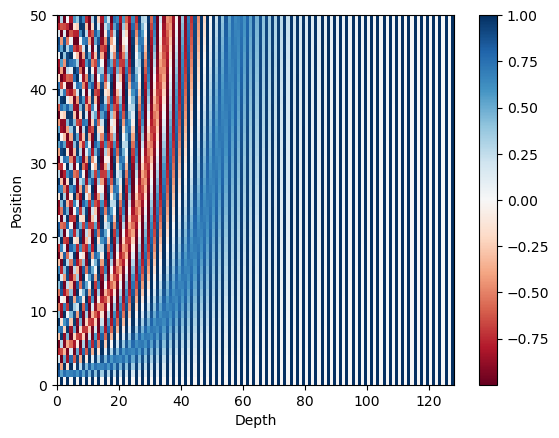

In [105]:
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [106]:
# cos과 sin이 반복되며 빨강, 파란색으로 나타나고 있다.(연속함수)(단어간의 위치 관계를 표현한 것)

In [107]:
# multi head attention
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name='multi_head_attention'):
        super(MultiHeadAttention, self).__init__(name=name) 
        self.num_heads = num_heads # 어텐션 헤드의 차원 크기(어텐션 헤드의 개수)
        self.d_model = d_model # 입출력 차원 크기

        assert d_model % self.num_heads == 0 # 나누어 떨어지는지 확인(그렇지 않으면 에러 출력)

        self.depth = d_model // self.num_heads

        # Dense Layer
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units = d_model)

    def split_heads(self, inputs, batch_size): # 입력 텐서를 여러 개로 분할
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth)) # reshape 처리
        return tf.transpose(inputs, perm=[0, 2, 1, 3]) # 다시 transpose로 변환 처리, (batch_size, self.num_heads, -1, self.depth)

    def call(self, inputs): # 입력 단계에서의 call 처리
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask'] # 각각 분할 후 값을 받아오고,
        batch_size = tf.shape(query)[0] # shape 처리

        # q : batch size, query의 길이, d_model
        # dense_Layer 통과
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # q, k, v를 num_head 개수만큼 분할한다.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 결합
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        outputs = self.dense(concat_attention)
        # print(outputs.shape)
        return outputs

In [108]:
# attention = MultiHeadAttention(256, 8)

In [1]:
# look ahead는 패딩도 사용한다.

In [109]:
def scaled_dot_product_attention(query, key, value, mask):
    # q와 k를 곱한다. attention score 행렬
    matmul_qk = tf.matmul(query, key, transpose_b = True)

    # 스케일링
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 마스킹(어텐션 스코어 행렬의 마스킹 위치에 매우 작음 음수값을 넣는다.)
    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1) # 작은 음수는 0으로 처리

    output = tf.matmul(attention_weights, value)

    return output, attention_weights

In [110]:
batch_size = 2
seq_len_q = 5
seq_len_k = 10
d_model = 512
num_heads = 8

query = np.random.rand(batch_size, seq_len_q, d_model).astype(np.float32)
key = np.random.rand(batch_size, seq_len_k, d_model).astype(np.float32)
value = np.random.rand(batch_size, seq_len_k, d_model).astype(np.float32)
mask = np.zeros((batch_size, 1, 1, seq_len_k)).astype(np.float32)

mha = MultiHeadAttention(d_model, num_heads)
inputs = {'query' : query, 'key' : key, 'value' : value, 'mask' : mask}
output = mha(inputs)

print('MultiHeadAttention', output.shape)

MultiHeadAttention (2, 5, 512)


In [156]:
# 인코더 레이어 생성
def encoder_layer(dff, d_model, num_heads, dropout, name='encoder_layer'):
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')

    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention = MultiHeadAttention(
        d_model, num_heads, name='attention')({
            'query':inputs, 'key':inputs, 'value':inputs, 'mask':padding_mask
        })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [157]:
# 인코더 생성
def encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='encoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')

    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32)) 
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings) # 위치정보 등록
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 쌓여있는 encoder layer에 이전 입력과 패딩 마스크를 전달한다.(개별 인코더 레이어들을 생성한다.)
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads, dropout=dropout, name='encoder_layer_{}'.format(i))([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [158]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

# [7, 6, 0, 0, 0] : 마지막 3개의 0을 마스킹

In [159]:
def create_look_ahead_mask(x): 
    seq_len = tf.shape(x)[1] # 입력 시퀸스 길이

    # linalg.band._part : 대각선 아래 부분만 1로 채워진 행렬(바로 및 실행코드 통해 직관적으로 확인 가능)
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x) # look_ahead_mask, padding_mask(패딩 토큰 식별)
    return tf.maximum(look_ahead_mask, padding_mask) # 두 개의 mask 통합(두 마스크의 큰 값을 결합하여 최종 마스크를 생성한다.

In [160]:
seq_len = 4
1-tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.]], dtype=float32)>

In [182]:
def decoder_layer(dff, d_model, num_heads, dropout, name='decoder_layer'):
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs') # 디코더 입력
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs') #인코더 출력

    # Look ahead mask(첫 번째 층)와 padding mask(두 번째 층) 둘 다 사용
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브층(마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name='attention_1')(inputs={
        'query':inputs, 'key':inputs, 'value':inputs, 'mask':look_ahead_mask
    })

    # dropout, 잔차연결, 정규화
    attention1 = tf.keras.layers.Dropout(rate=dropout)(attention1) # 과적합 방지
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브층(셀프 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name='attention_2')(inputs={
        'query':attention1, 'key':enc_outputs, 'value':enc_outputs, 'mask':padding_mask
    })

    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2) # 과적합 방지
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1) # 잔차연결, 정규화 처리 시 attention1과 attention2를 결합

    # 세 번째 서브층
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # dropout, 잔차연결, 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

In [183]:
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs') # 디코더 입력
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs') # 인코더 출력
 
    # Look ahead mask, padding mask 둘 다 사용 ⭐️
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask') # 첫 번째 서브층
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask') # 두 번째 서브층

    # 임베딩, 포지셔널 인코딩, 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32)) # 임베딩 값에 스케일링 값을 곱해준다.
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings) # 입력 시퀸스에 위치 정보를 인코딩
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings) # 과적합 방지

    for i in range(num_layers): # 이전 디코더의 출력, 인코더의 출력, mask를 통해 다음 출력을 생성
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads, dropout=dropout, name='decoder_layer_{}'.format(i))(
            inputs = [outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

In [184]:
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='transformer'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    dec_inputs = tf.keras.Input(shape=(None,), name='dec_inputs')

    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs)
    
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None), name='look_ahead_mask')(dec_inputs)
    
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask')(inputs)
    
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff, d_model=d_model, num_heads=num_heads, dropout=dropout)(inputs=[inputs, enc_padding_mask])
    
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff, d_model=d_model, num_heads=num_heads, dropout=dropout)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    outputs = tf.keras.layers.Dense(units=vocab_size, name='outputs')(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

(1, 9000, 128)
(1, 9000, 128)


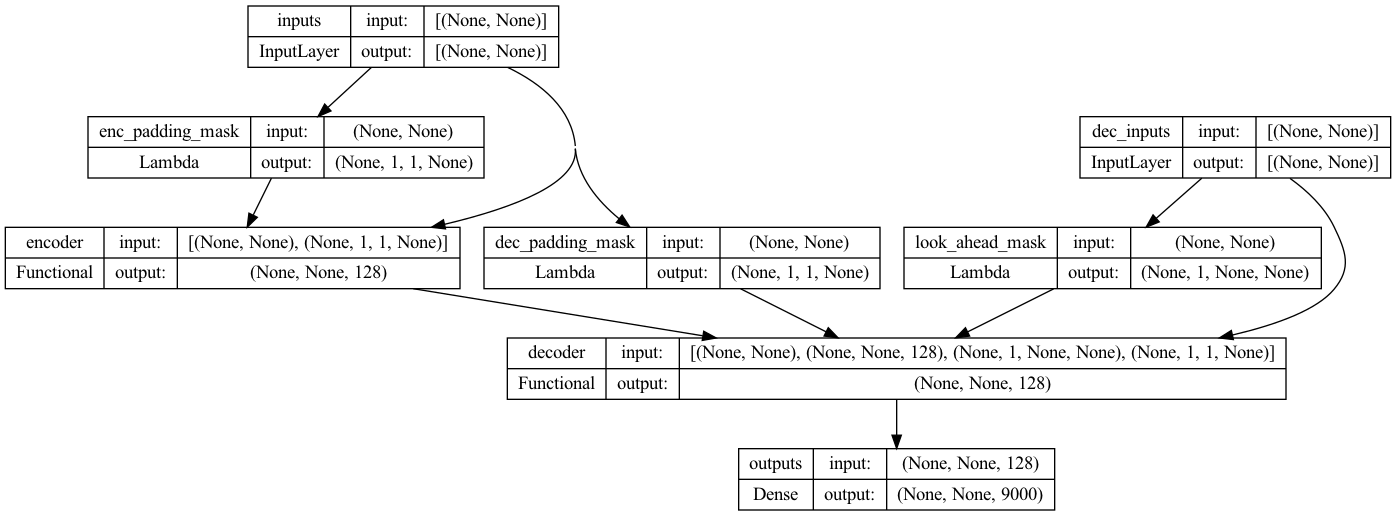

In [185]:
small_transformer = transformer(vocab_size=9000, num_layers=4, dff=512, d_model=128, num_heads=4, dropout=0.2, name='small_transformer')

tf.keras.utils.plot_model(small_transformer, show_shapes=True)